# Convolutional neural net with embeddings
Adapted from code at https://github.com/fchollet/keras/blob/master/examples/imdb_cnn.py

## Importing objects and setting parameters

In [10]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix, \
                    accuracy_score, roc_curve, auc

import matplotlib.pyplot as plt


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
df = pd.read_csv('data/final.zip', compression='zip')
df.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,TOXIC,...,word_counts,unique_word_counts,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,...,43,41,explanation why the edits made under my userna...,"['explanation', 'why', 'the', 'edits', 'made',...","['explanation', 'edits', 'made', 'username', '...","['explan', 'edit', 'made', 'usernam', 'hardcor...","[('explanation', 'NN'), ('edits', 'NNS'), ('ma...","['explanation', 'edits', 'made', 'username', '...","['explanation', 'edits', 'make', 'username', '...","[('explanation', 'edits'), ('edits', 'made'), ..."
1,1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,...,17,17,daww he matches this background colour i am se...,"['daww', 'he', 'matches', 'this', 'background'...","['daww', 'matches', 'background', 'colour', 's...","['daww', 'match', 'background', 'colour', 'see...","[('daww', 'NN'), ('matches', 'NNS'), ('backgro...","['daww', 'match', 'background', 'colour', 'see...","['daww', 'match', 'background', 'colour', 'see...","[('daww', 'matches'), ('matches', 'background'..."
2,2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,...,42,39,hey man i am really not trying to edit war it ...,"['hey', 'man', 'i', 'am', 'really', 'not', 'tr...","['hey', 'man', 'really', 'trying', 'edit', 'wa...","['hey', 'man', 'realli', 'tri', 'edit', 'war',...","[('hey', 'NN'), ('man', 'NN'), ('really', 'RB'...","['hey', 'man', 'really', 'trying', 'edit', 'wa...","['hey', 'man', 'really', 'try', 'edit', 'war',...","[('hey', 'man'), ('man', 'really'), ('really',..."
3,3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,...,113,82,more i cannot make any real suggestions on im...,"['more', 'i', 'can', 'not', 'make', 'any', 're...","['make', 'real', 'suggestions', 'improvement',...","['make', 'real', 'suggest', 'improv', 'wonder'...","[('make', 'VB'), ('real', 'JJ'), ('suggestions...","['make', 'real', 'suggestion', 'improvement', ...","['make', 'real', 'suggestion', 'improvement', ...","[('make', 'real'), ('real', 'suggestions'), ('..."
4,4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,...,13,13,you sir are my hero any chance you remember wh...,"['you', 'sir', 'are', 'my', 'hero', 'any', 'ch...","['sir', 'hero', 'chance', 'remember', 'page']","['sir', 'hero', 'chanc', 'rememb', 'page']","[('sir', 'NN'), ('hero', 'NN'), ('chance', 'NN...","['sir', 'hero', 'chance', 'remember', 'page']","['sir', 'hero', 'chance', 'remember', 'page']","[('sir', 'hero'), ('hero', 'chance'), ('chance..."


In [3]:
df['comment_text'][0], df['clean_text'][0]

("Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now')

In [4]:
#return dictionary with word: embedding_vector
def load_embedding(fname):
    embeddings_index = {}
    f = open(fname, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            embedding_vector = np.asarray(values[1:], dtype='float32')
        except:
            pass
        
        embeddings_index[word] = embedding_vector
    f.close()

    return embeddings_index

In [11]:
def build_CNN_model(word_index, embeddings_index, N_CLASSES, MAX_SEQUENCE_LENGTH, EMBEDDING_DIMS):
    print('Build model...')
    model = Sequential()
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIMS))

    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    model.add(Embedding(len(word_index) + 1,
                              EMBEDDING_DIMS,
                              weights=[embedding_matrix],
                              input_length=MAX_SEQUENCE_LENGTH,
                              trainable=False))

    model.add(Conv1D(10, 3, activation='relu'))
    
    model.add(MaxPooling1D())

    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(N_CLASSES, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
  
    return model

# Binary Task (toxic vs no_toxic)

In [5]:
text = df.comment_text.values
target = df.TOXIC.values

#Parameters
N_CLASSES=1
MAX_WORDS=20000
MAX_SEQUENCE_LENGTH=200
EMBEDDING_DIMS = 50

tokenizer = Tokenizer(num_words=MAX_WORDS) 
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text) 
sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
embeddings_index = load_embedding("glove.6B.50d.txt")
#embeddings_index = load_embedding("./wiki.simple.vec")

x_train, x_test, y_train, y_test = train_test_split(sequences, target, test_size=0.2, random_state=100)

print(f'train sequences {len(x_train)}')
print(f'test sequences {len(x_test)}')
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

train sequences 178839
test sequences 44710
x_train shape: (178839, 200)
x_test shape: (44710, 200)


In [6]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [90]:
filters=128
kernel_size=5

model = Sequential()
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIMS))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model.add(Embedding(len(word_index) + 1,
                          EMBEDDING_DIMS,
                          weights=[embedding_matrix],
                          input_length=MAX_SEQUENCE_LENGTH,
                          trainable=False))

model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D())

model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(N_CLASSES, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model = build_CNN_model(word_index, embeddings_index, N_CLASSES, MAX_SEQUENCE_LENGTH, EMBEDDING_DIMS)
model.summary()

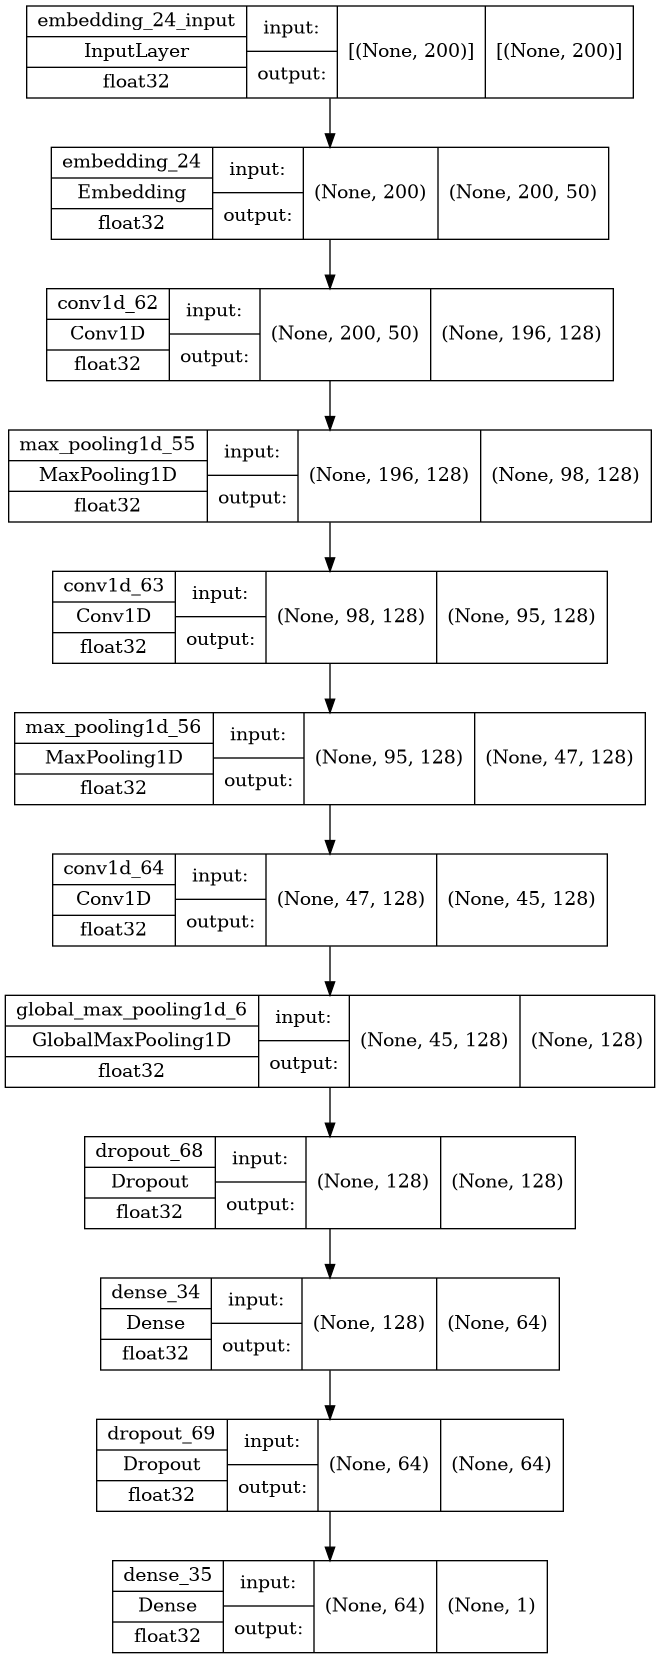

In [91]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [92]:
epochs = 10
batch_size=1024

history = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=epochs)

Epoch 1/10
175/175 [==============================] - 15s 82ms/step - loss: 0.2605 - accuracy: 0.9060 - val_loss: 0.1968 - val_accuracy: 0.9269
Epoch 2/10
175/175 [==============================] - 14s 81ms/step - loss: 0.1896 - accuracy: 0.9303 - val_loss: 0.1759 - val_accuracy: 0.9338
Epoch 3/10
175/175 [==============================] - 14s 81ms/step - loss: 0.1735 - accuracy: 0.9355 - val_loss: 0.1757 - val_accuracy: 0.9348
Epoch 4/10
175/175 [==============================] - 14s 81ms/step - loss: 0.1652 - accuracy: 0.9384 - val_loss: 0.1688 - val_accuracy: 0.9371
Epoch 5/10
175/175 [==============================] - 14s 83ms/step - loss: 0.1569 - accuracy: 0.9410 - val_loss: 0.1670 - val_accuracy: 0.9378
Epoch 6/10
175/175 [==============================] - 15s 83ms/step - loss: 0.1503 - accuracy: 0.9432 - val_loss: 0.1687 - val_accuracy: 0.9376
Epoch 7/10
175/175 [==============================] - 15s 84ms/step - loss: 0.1435 - accuracy: 0.9453 - val_loss: 0.1660 - val_accuracy:

In [93]:
history.history

{'loss': [0.26050153374671936,
  0.18964357674121857,
  0.17350001633167267,
  0.16515617072582245,
  0.15685497224330902,
  0.1503419429063797,
  0.14353039860725403,
  0.13611562550067902,
  0.13060089945793152,
  0.12051387876272202],
 'accuracy': [0.9059545397758484,
  0.930328369140625,
  0.935517430305481,
  0.9384138584136963,
  0.940952479839325,
  0.9431891441345215,
  0.9453195333480835,
  0.9481600522994995,
  0.9501451253890991,
  0.9544562697410583],
 'val_loss': [0.19684337079524994,
  0.1758960634469986,
  0.17567476630210876,
  0.16882479190826416,
  0.16701048612594604,
  0.16867771744728088,
  0.166024848818779,
  0.17784646153450012,
  0.17684142291545868,
  0.1887352168560028],
 'val_accuracy': [0.9269291162490845,
  0.9337508678436279,
  0.934779703617096,
  0.9371057748794556,
  0.9377768039703369,
  0.9375754594802856,
  0.9374412894248962,
  0.9371952414512634,
  0.9377320408821106,
  0.9277343153953552]}

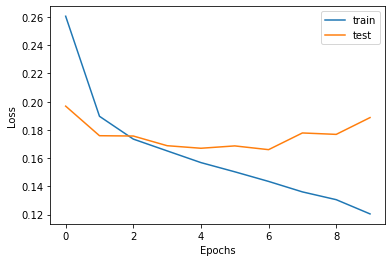

In [94]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

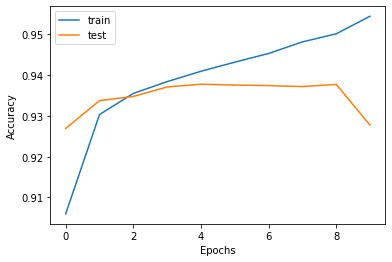

In [95]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [96]:
predictions_prob = model.predict(x_test)
predictions = predictions_prob.round()

In [97]:
print(classification_report(y_test, predictions))
confusion_matrix(y_test, predictions)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     40196
           1       0.64      0.65      0.64      4514

    accuracy                           0.93     44710
   macro avg       0.80      0.80      0.80     44710
weighted avg       0.93      0.93      0.93     44710



array([[38559,  1637],
       [ 1594,  2920]])

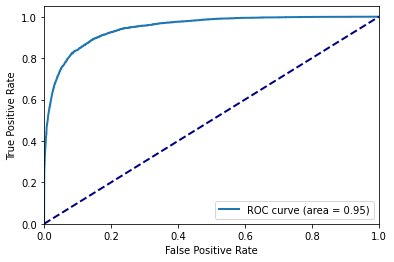

In [72]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, predictions_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()